#Importing all necessary libraries

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer,Layer,Dense,MaxPooling2D,Conv2D,Flatten,Dropout,BatchNormalization,RandomFlip,RandomRotation,Resizing,Rescaling
from tensorflow.keras.layers import Normalization,Dropout,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt






# Getting the dataset

In [ ]:
df,df_info=tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.5Q4SHZ_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


# Train-Test split

In [ ]:
def splits(df,TRAIN_RATIO,VAL_RATIO,TEST_RATIO):

    DATASET_SIZE = len(df)

    df_train = df.take(int(TRAIN_RATIO * DATASET_SIZE))
    #print("Train dataset:", list(df_train.as_numpy_iterator()))

    df_val_test = df.skip(int(TRAIN_RATIO * DATASET_SIZE))
    df_val = df_val_test.take(int(VAL_RATIO * DATASET_SIZE))
    #print("Validation dataset:", list(df_val.as_numpy_iterator()))

    df_test= df_val_test.skip(int(VAL_RATIO * DATASET_SIZE))
    #print("Test dataset:", list(df_test.as_numpy_iterator()))

    return df_train,df_val,df_test

In [ ]:

TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset,val_dataset,test_dataset=splits(df[0],TRAIN_RATIO,VAL_RATIO,TEST_RATIO)
#print(list(train_dataset.take(1).as_numpy_iterator()))
#print(list(val_dataset.take(1).as_numpy_iterator()))
#print(list(test_dataset.take(1).as_numpy_iterator()))


# Getting the first 15 picture

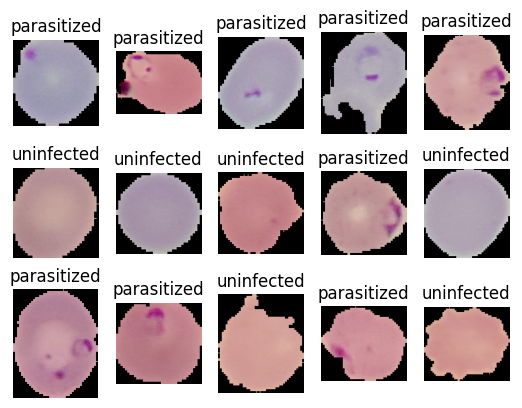

In [ ]:
for i,(image,label) in enumerate(train_dataset.take(15)):
    ax=plt.subplot(3,5,i+1)
    plt.imshow(image)
    plt.title(df_info.features['label'].int2str(label))
    plt.axis('off')


# Data Augmentation

In [ ]:
def visualization(original,augmented):
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


In [ ]:
original_image,label=next(iter(train_dataset))


In [ ]:
augmented_image=tf.image.random_flip_up_down(
    original_image
)



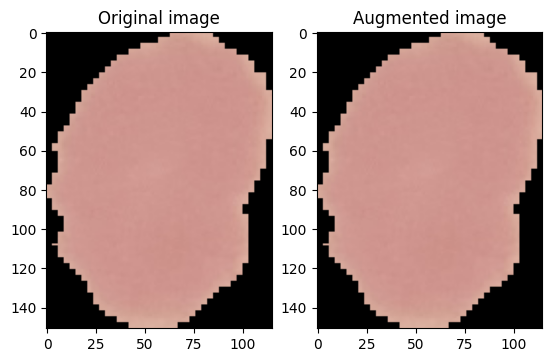

In [ ]:
visualization(original_image,augmented_image)

#Resizing all images to be standard

In [ ]:
def resizing(image,label):
    image=tf.image.resize(image,(224,224))/255.0
    return image,label

In [ ]:
def augment(image,label):
  image,label=resizing(image,label)
  image=tf.image.random_flip_left_right(image)
  image=tf.image.rot90(image,k=tf.random.uniform(shape=[],minval=0,maxval=2,dtype=tf.int32))
  image=tf.image.stateless_random_saturation(image,0.3,0.5)
  #image=tf.image.adjust_saturation  (image,0.2)
  return image,label

In [ ]:
class RotNinety(Layer):
  def __init__(self):
    super().__init__()
  def call(self,image):
    return tf.image.rot90(image)

In [ ]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(224,224),
    Rescaling(1.0/255)
])
    # Flip horizontally


# Define the augmentation layers in a Sequential model
augment_layer = tf.keras.Sequential([
    RandomFlip(mode='horizontal', seed=None),  # Flip horizontally
    RotNinety()
    ])

def augment_with_layers(image, label):

    return augment_layer(resize_rescale_layer(image),training=True), label

In [ ]:
test_dataset=test_dataset.map(resizing)

In [ ]:
for image,label in train_dataset:
  print(image.shape)
  break;


(103, 103, 3)


# Shuffling

In [ ]:
#train_dataset = (
 #    train_dataset
  #  .shuffle(buffer_size=1024, reshuffle_each_iteration=True)
    #.map(augment_with_layers, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation before batching
    #.batch(32)
    #.prefetch(tf.data.AUTOTUNE)
#)


val_dataset=(
    val_dataset
     .map(resizing,num_parallel_calls=tf.data.AUTOTUNE)
     .batch(32)

)

train_dataset


<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
val_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Mix up Data Augmentation

In [ ]:
# USING ALBUMENTATION INSTEAD OF MIX UP
train_dataset_1=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing)
train_dataset_2=train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True).map(resizing)

mixed_dataset=tf.data.Dataset.zip((train_dataset_1,train_dataset_2))

In [ ]:
def mixup(train_dataset_1,train_dataset_2):
  (image_1,label_1),(image_2,label_2)=train_dataset_1,train_dataset_2
  lamda=tfp.distributions.Beta(0.4,0.4)
  lamda=lamda.sample(1)[0]

  image=lamda*image_1 + (1-lamda)*image_2
  label=lamda*tf.cast(label_1,dtype=tf.float32 )+ (1-lamda)*tf.cast(label_2,dtype=tf.float32)

  return image,label


In [ ]:
train_dataset=(
    mixed_dataset.shuffle
     (buffer_size=8,
      reshuffle_each_iteration=True)
     .map(mixup)
     .batch(32)
     .prefetch(tf.data.AUTOTUNE)
)



In [ ]:
train_dataset

In [ ]:
val_dataset

#Cropping

In [ ]:
#THIS IS JUST A TEST THAT IS NOT INCLUDEDED IN THE MODEL

plt.figure(figsize=(10,10))

img_1=cv2.resize(cv2.imread('cat.jpeg'),(224,224))
plt.subplot(1,7,1)
plt.imshow(img_1)

plt.subplot(1,7,2)
img_2=cv2.resize(cv2.imread('dog.jpg'),(224,224))
plt.imshow(img_2)

plt.subplot(1,7,3)
cropped=tf.image.crop_to_bounding_box(img_2,offset_height=20,offset_width=15,target_height=100,target_width=98)
plt.imshow(cropped)

plt.subplot(1,7,4)
img_4=tf.image.pad_to_bounding_box(cropped,20,100,224,224)
plt.imshow(img_4)

plt.subplot(1,7,5)
img_4=tf.image.pad_to_bounding_box(cropped,20,100,224,224)
plt.imshow(img_4+img_1)

plt.subplot(1,7,6)
crop_cat=tf.image.crop_to_bounding_box(img_1,offset_height=20,offset_width=100,target_height=100,target_width=98)
plt.imshow(crop_cat)

plt.subplot(1,7,7)
img_5=tf.image.pad_to_bounding_box(crop_cat,20,100,224,224)
plt.imshow(img_1-img_5+img_4)



# Albumentation

In [ ]:
transforms=A.Compose([
    A.Resize(224,224),
    A.OneOf([A.HorizontalFlip(),
    A.VerticalFlip(),
    ],p=0.3),
    A.RandomRotate90(),




])

In [ ]:
def aug_albument(image):
  data={"image":image}
  image=transforms(**data)
  image=image["image"]
  image=tf.cast(image/255.,tf.float32)
  return image

In [ ]:
def process_data(image,label):
  aug_img=tf.numpy_function(func=aug_albument,inp=[image],Tout=tf.float32)
  aug_img.set_shape((224,224,3))
  return aug_img,label


In [ ]:
for image, label in train_dataset.take(1):
    print("Shape of image:", image.shape)  # Should be (224, 224, 3)


Shape of image: (103, 103, 3)


In [ ]:
train_dataset=(
      train_dataset.shuffle
     (buffer_size=1024,reshuffle_each_iteration=True)
     .map(process_data,)
     .batch(32)
     .prefetch(tf.data.AUTOTUNE)
)


In [ ]:

print(train_dataset)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


# Creating a neural network

In [ ]:
model=tf.keras.Sequential([
    InputLayer(input_shape=(None,None,3)),
    resize_rescale_layer,
    augment_layer,



    tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid',activation='relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2),
    Dropout(0.2),
    tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding='valid',activation='relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=2,strides=2),

    Flatten(),
    Dense(units=100,activation='relu',kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(units=10,activation='relu'),
    BatchNormalization(),
    Dense(units=1,activation='sigmoid')


])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 46656)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,665,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,668,297 (17.81 MB)

 Trainable params: 4,668,033 (17.81 MB)

 Non-trainable params: 264 (1.03 KB)

# Compiling the model

In [ ]:
model.compile(optimizer='adam',loss=BinaryCrossentropy(),metrics=['accuracy'],run_eagerly=False)

# Fitting the model

In [ ]:
history=model.fit(train_dataset,epochs=10,validation_data=val_dataset,verbose=1)

Epoch 1/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 112s 143ms/step - accuracy: 0.6423 - loss: 1.6724 - val_accuracy: 0.4973 - val_loss: 1.0133
Epoch 2/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 120ms/step - accuracy: 0.7263 - loss: 0.8752 - val_accuracy: 0.7528 - val_loss: 1.0477
Epoch 3/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.9116 - loss: 0.5707 - val_accuracy: 0.9347 - val_loss: 0.4738
Epoch 4/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 150s 132ms/step - accuracy: 0.9287 - loss: 0.4602 - val_accuracy: 0.9397 - val_loss: 0.4722
Epoch 5/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.9269 - loss: 0.4563 - val_accuracy: 0.4926 - val_loss: 0.8015
Epoch 6/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 148s 130ms/step - accuracy: 0.9289 - loss: 0.4344 - val_accuracy: 0.9230 - val_loss: 0.5205
Epoch 7/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 84s 121ms/step - accuracy: 0.9259 - loss: 0.4189 - val_accuracy: 0.9194 - val_loss: 0.4517
Epoch 8/10
689/689 ━━━━━━━━━━━━━━━━━━━━ 148s 129ms/step - accuracy: 0.9261 - los

# Plotting loss

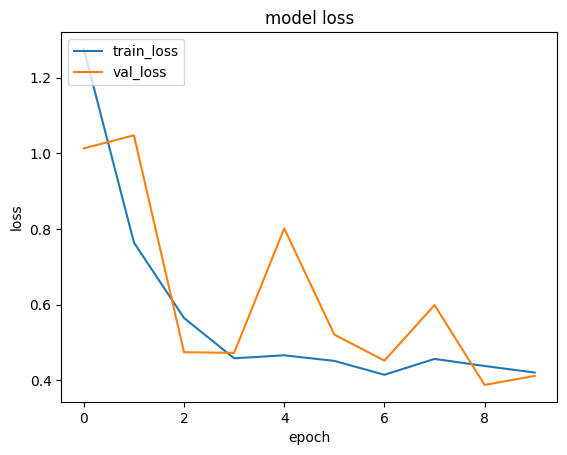

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

# Plotting accuracy

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

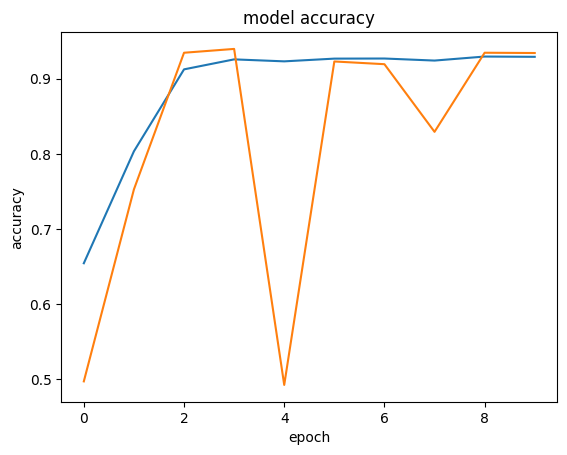

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt

In [ ]:
test_dataset=test_dataset.batch(1)


In [ ]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Evaluating

In [ ]:
model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.9293 - loss: 0.4257


[0.4286845624446869, 0.9263692498207092]

# Predicting the test dataset which the model didn't see

In [ ]:
def is_parasite(x):
  if x<0.5:
    return 'P'#Parasite
  else:
    return 'U'#Uninfected


In [ ]:
is_parasite(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step


'U'

# Displaying the prediction and the real value

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


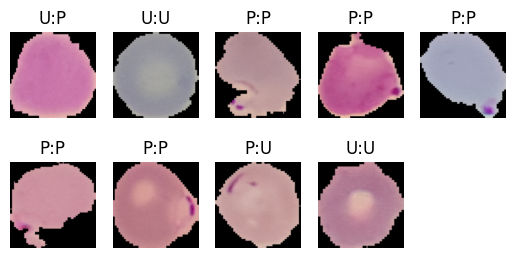

In [ ]:
for i ,(image,label) in enumerate(test_dataset.take(9)):
  ax=plt.subplot(3,5,i+1)
  plt.imshow(image[0])
  plt.title(str(is_parasite(label.numpy()[0]))+ ":" +str(is_parasite(model.predict(image)[0][0])))
  plt.axis('off')

#Giving the model a random image to test


In [ ]:
image=cv2.imread("malaria.jpg")
print(image.shape)
image=tf.expand_dims(image,axis=0)
print(image.shape)

is_parasite(model.predict(image))

(351, 450, 3)
(1, 351, 450, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step


'P'